In [1]:
from eye_tracking_utils import *

**GOAL**: this matching uses the vscode plugin and the eye tracking data as primary sources almost disregarding the video which is used only to double check what was going on.

# 0. Parameters

In [2]:
SHOW_USERNAME_NR = 3
VALID_USERNAMES_AND_ZOOM = [
    ["UconsumerU", "M"],
    ["UquarterU", "M"],
    ["UpassionU", "M"],
    ["UmonkU", "M"],
    ["UsalvationU", "L"],
    ["UimproveU", "L"],
    ["UcharterU", "L"],
    ["UpopU", "L"],
]

USER_NAME = VALID_USERNAMES_AND_ZOOM[SHOW_USERNAME_NR][0]
USER_ZOOM = VALID_USERNAMES_AND_ZOOM[SHOW_USERNAME_NR][1]
TASK_NUMBER = 1
DIR_PARTICIPANTS = "../participants"
DIR_QUESTIONS = "../samples"
USER_FOLDER = os.path.join(DIR_PARTICIPANTS, USER_NAME)

In [3]:
%load_ext autoreload
%autoreload 2

# 1. Read Data (iTracker and Eye Tracker)

In [4]:
df_text = read_textual_snapshot(user_folder=USER_FOLDER)
print(df_text.info())
df_text.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1286 entries, 0 to 1285
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             1286 non-null   float64
 1   source_filename  1286 non-null   object 
 2   content_lines    1286 non-null   object 
dtypes: float64(1), object(2)
memory usage: 30.3+ KB
None


,time,source_filename,content_lines
0,38280660.0,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,"[\n, bool isSafe(int board[N][N], int row, int..."
1,38894688.0,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,"[\n, if (l == h)\n, return root;\n..."
2,37952459.0,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,"[\tfor (int i = 0; i < N; i++)\n, \t{\n, \t\ti..."
3,38248332.0,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,"[\n, \n, #include <bits/stdc++.h>\n, #define N..."
4,38709500.0,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,"[#include <bits/stdc++.h>\n, using namespace s..."


In [5]:
df_eye = read_eye_tracker_fixations(user_folder=USER_FOLDER, task_nr=TASK_NUMBER)
df_eye = offset_time_based_on_time_column(df_eye)
df_eye = df_eye.rename(columns={"time_abs": "time"})
print(df_eye.info())
df_eye.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931 entries, 0 to 930
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDIA_ID                       931 non-null    int64  
 1   MEDIA_NAME                     931 non-null    object 
 2   CNT                            931 non-null    int64  
 3   TIME(2022/07/21 10:31:12.676)  931 non-null    float64
 4   TIMETICK(f=10000000)           931 non-null    int64  
 5   FPOGX                          931 non-null    float64
 6   FPOGY                          931 non-null    float64
 7   FPOGS                          931 non-null    float64
 8   FPOGD                          931 non-null    float64
 9   FPOGID                         931 non-null    int64  
 10  FPOGV                          931 non-null    int64  
 11  BPOGX                          931 non-null    float64
 12  BPOGY                          931 non-null    flo

,MEDIA_ID,MEDIA_NAME,CNT,TIME(2022/07/21 10:31:12.676),TIMETICK(f=10000000),FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,...,TTLV,PIXS,PIXV,AOI,SACCADE_MAG,SACCADE_DIR,VID_FRAME,Unnamed: 51,time,FPOGS_abs
0,0,NewMedia0,30,0.48486,48171806160,0.53484,0.52698,0.00000,0.48487,1,...,0,0.0,0,NaN,0.00000,0.00000,0,NaN,37873160.86,37872676.00
1,0,NewMedia0,56,0.90576,48176012679,0.53730,0.43816,0.50098,0.40479,2,...,0,0.0,0,NaN,96.04177,87.18117,0,NaN,37873581.76,37873176.98
2,0,NewMedia0,108,1.74658,48184423466,0.54111,0.43305,0.92188,0.82471,3,...,0,0.0,0,NaN,9.16346,37.03202,0,NaN,37874422.58,37873597.88
3,0,NewMedia0,128,2.07031,48187658679,0.48028,0.88297,1.81104,0.25928,4,...,0,0.0,0,NaN,499.75262,256.48483,0,NaN,37874746.31,37874487.04
4,0,NewMedia0,146,2.36133,48190570319,0.52029,0.99850,2.13477,0.22656,5,...,0,0.0,0,NaN,146.52426,301.61954,0,NaN,37875037.33,37874810.77


In [6]:
# convert timestamp to datetime
first_ts_text = df_text.sort_values("time").iloc[0]["time"]
first_ts_eye = df_eye.sort_values("time").iloc[0]["time"]
print("Text: ", datetime.fromtimestamp(first_ts_text))
print("Eye: ", datetime.fromtimestamp(first_ts_eye))

Text:  1971-03-10 06:45:15
Eye:  1971-03-15 09:19:20.860000


In [7]:
eye_events = df_eye[["time", "FPOGX", "FPOGY", "FPOGD"]].to_dict(orient="records")
eye_events = [{"source": "eye", **e} for e in eye_events]
text_events = df_text[["time", "source_filename", "content_lines"]].to_dict(orient="records")
text_events = [{"source": "text", **e} for e in text_events]
all_events = eye_events + text_events
df_txt_and_eye = pd.DataFrame.from_records(all_events)
df_txt_and_eye.head(2000)

,source,time,FPOGX,FPOGY,FPOGD,source_filename,content_lines
0,eye,37873160.86,0.53484,0.52698,0.48487,NaN,NaN
1,eye,37873581.76,0.53730,0.43816,0.40479,NaN,NaN
2,eye,37874422.58,0.54111,0.43305,0.82471,NaN,NaN
3,eye,37874746.31,0.48028,0.88297,0.25928,NaN,NaN
4,eye,37875037.33,0.52029,0.99850,0.22656,NaN,NaN
...,...,...,...,...,...,...,...
1995,text,38429260.00,NaN,NaN,NaN,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,"[\t\t: x(x), y(y)\n, \t{\n, \t}\n, };\n, \n, i..."
1996,text,37756849.00,NaN,NaN,NaN,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,"[\t\t\t\t\tchar to_rod, char aux_rod)\n, {\n, ..."
1997,text,38786437.00,NaN,NaN,NaN,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,"[ int l, int h, int siz..."
1998,text,38172668.00,NaN,NaN,NaN,c:\Users\DevDiv2-PAR\Documents\GitHub\attentio...,"[{\n, \tif (col >= N)\n, \t\treturn true;\n, \..."


<AxesSubplot:xlabel='time', ylabel='Count'>

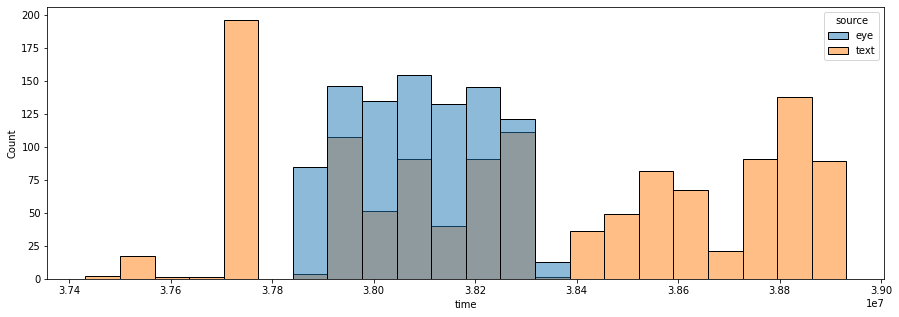

In [8]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    data=df_txt_and_eye,
    x="time",
    hue="source",
    ax=ax
)

# 3. Get Grid on a single video Frame



In [9]:
user_zoom = USER_ZOOM

video_path = get_video_path(user_folder=USER_FOLDER, task_nr=TASK_NUMBER)
# get the middle frame
data = get_tot_n_frames(video_path)
tot_n_frames = data["tot_n_frames"]
mid_frame = int(tot_n_frames // 2)
img, img_path = get_video_image(video_path=video_path, frame_number=mid_frame, output_folder="./tmp")
print(img_path)
# screen coordinates
if user_zoom == "M":
    marker_params = {
        "path_marker_top_left": "../markers/top_left_marker.png",
        "path_marker_bottom_right": "../markers/bottom_right_marker.png",
        "top_left_offsets": (182, 109),
        "bottom_right_offsets": (107, 6),
    }
    col_lines_params = {"n_lines": 26, "n_col": 97,}
elif user_zoom == "L":
    marker_params = {
        "path_marker_top_left": "../markers/top_left_marker_zoomed.png",
        "path_marker_bottom_right": "../markers/bottom_right_marker_zoomed.png",
        "top_left_offsets": (220, 125),
        "bottom_right_offsets": (90, -25),
    }
    col_lines_params = {"n_lines": 20, "n_col": 71,}

code_screen_coordinate_abs = get_code_coordinates(
    screenshot_path=img_path,
    percentage_format=False,
    debug=False,
    **marker_params)
code_screen_coordinate_abs

./tmp/UmonkU_frame_2250.jpg


{'x_start_screen_abs': 493,
 'y_start_screen_abs': 151,
 'x_end_screen_abs': 1785,
 'y_end_screen_abs': 1000}

# 4. Convert all (x, y) coord to char



In [10]:
# keep only the text data in between eye tracking data
# because the rest refer to a different task
first_ts_eye = df_eye.sort_values("time").iloc[0]["time"]
last_ts_eye = df_eye.sort_values("time").iloc[-1]["time"]
# filter and keep the text data with time between the first and last ts eye
df_txt_and_eye = df_txt_and_eye[
    (df_txt_and_eye["time"] >= first_ts_eye) & (df_txt_and_eye["time"] <= last_ts_eye)
]

In [11]:
# get the file in the IDE in the middle of the task as the one under study
df_focus_on_snapshots = df_txt_and_eye[df_txt_and_eye["source"] == "text"]
mid_point = len(df_focus_on_snapshots) // 2
mid_point_filepath = df_focus_on_snapshots.iloc[mid_point]["source_filename"]
file_name = re.search(
    "([a-zA-Z0-9 _.]+):[0-9]+\n$", mid_point_filepath).group(1)
folder = re.search(
    "\\\\([a-zA-Z]+)\\\\[a-zA-Z0-9 _.]+:[0-9]+\n$", mid_point_filepath).group(1)
target_file_path = join(folder, file_name)
target_file_path

'cpp/Nqueens_Q3.cpp'

In [12]:
horizontal_attention_span = 6
vertical_attention_span = 1

current_text_snapshot = None

char_attribution_list = []

# scan the data sequentially in order of time
for i, event in df_txt_and_eye.sort_values(by="time").iterrows():

    # every time we get a new text event, we update the text snapshot
    if event["source"] == "text":
        current_text_snapshot = event
    # every time we get a new eye event, we compute the attention span since 
    # the last eye event
    elif event["source"] == "eye":
        if current_text_snapshot is None:
            continue
        time_elapsed_on_this_fixation = event["FPOGD"]

        fixation_X = event["FPOGX"]
        fixation_Y = event["FPOGY"]
        snapshot_line_start = int(
            re.search(":([0-9]+)\n$", current_text_snapshot["source_filename"]).group(1))

        (main_char_line_index, main_char_col_index) = get_char_coordinates(
            eye_x_perc=fixation_X, eye_y_perc=fixation_Y,
            pixel_screen_width=1920, pixel_screen_height=1080,
            debug=False,
            **col_lines_params,
            **code_screen_coordinate_abs)

        char_coordinates = convert_char_coordinate_to_attention_area(
            line=main_char_line_index,
            col=main_char_col_index,
            content="".join(current_text_snapshot["content_lines"]).replace("\t", "    "),
            content_starting_line=snapshot_line_start,
            horizontal_attention_span=horizontal_attention_span,
            vertical_attention_span=vertical_attention_span,
            tot_screen_col=col_lines_params["n_col"],
            tot_screen_lines=col_lines_params["n_lines"],
            #debug=debug
        ) 
        # add time info to all the coordinates
        char_coordinates = [
            {"line": int(c[0]), 
             "column": int(c[1]), 
             "time_spent": time_elapsed_on_this_fixation}
            for c in char_coordinates]
        char_attribution_list.extend(char_coordinates)


df_results = pd.DataFrame.from_records(char_attribution_list)
df_results.head()


,line,column,time_spent
0,0,2,0.29102
1,0,3,0.29102
2,0,4,0.29102
3,0,5,0.29102
4,0,6,0.29102




# 5. Visualize weights

In [13]:
df_results.groupby(by=["line", "column"]).sum().reset_index()

,line,column,time_spent
0,0,1,0.69482
1,0,2,0.98584
2,0,3,0.98584
3,0,4,0.98584
4,0,5,0.98584
...,...,...,...
4306,95,24,0.32373
4307,95,25,0.32373
4308,95,26,0.32373
4309,95,27,0.32373


In [14]:
from eye_tracking_utils import convert_char_attribution_to_tokens_and_weights

char_level_tokens, att_weights = convert_char_attribution_to_tokens_and_weights(
    df_char_attribution=df_results,
    source_code_file_path=join(DIR_QUESTIONS, target_file_path),
    tot_screen_lines=int(col_lines_params["n_lines"]),
    tot_screen_col=int(col_lines_params["n_col"]),
)

In [15]:

from codeattention.source_code import SourceCode

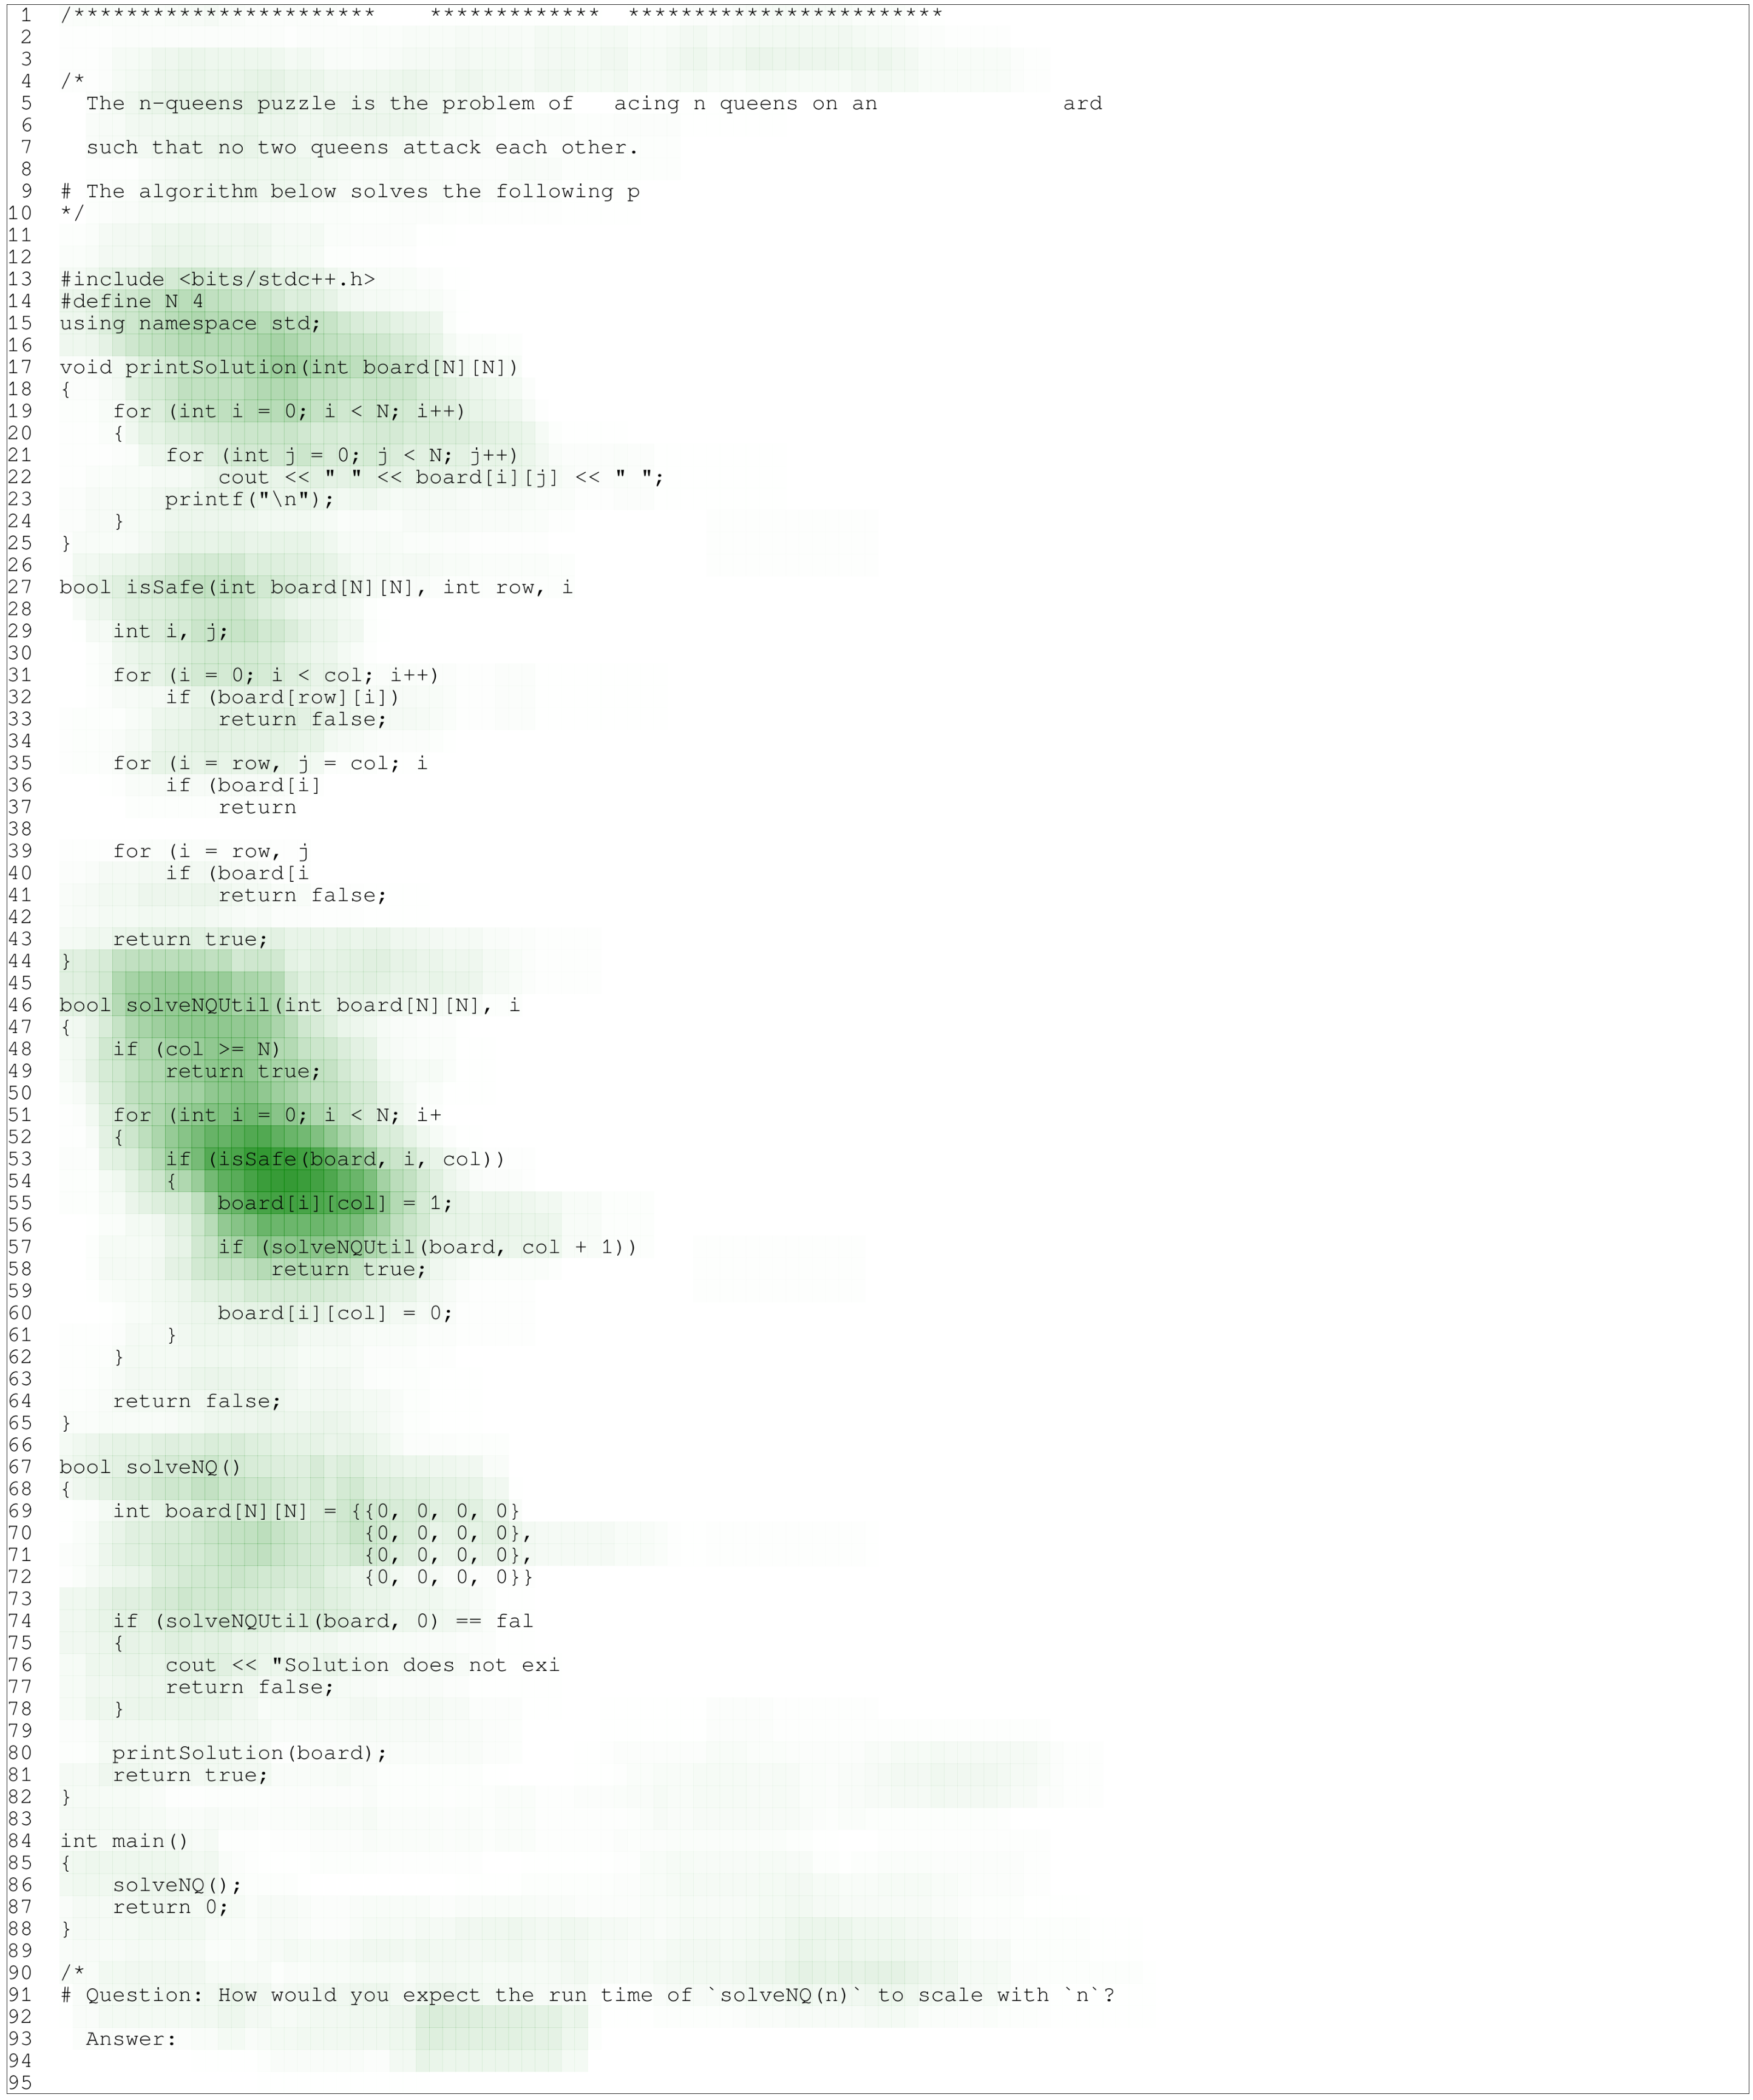

In [16]:
my_source_code = SourceCode(char_level_tokens)

fig, ax = my_source_code.show_with_weights(
    weights=att_weights, show_line_numbers=True)

## Heatmap of unseen chars

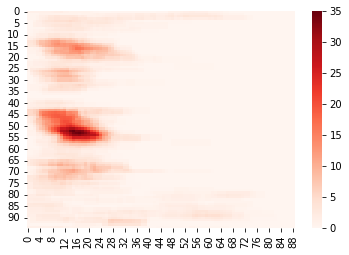

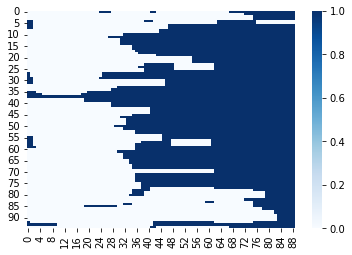

In [17]:
max_width = int(df_results["column"].max())
max_height = int(df_results["line"].max())
matrix = np.zeros((max_height, max_width))

for i, row in df_results.iterrows():
    matrix[int(row["line"] - 1), int(row["column"] - 1)] += row["time_spent"]

# get the position of row and column of the zero values in the matrix
zero_positions = np.where(matrix == 0)
positions_never_attended = [
    {"line": int(c[0]), "column": int(c[1]), "time_spent": 0}
    for c in zip(zero_positions[0], zero_positions[1])]
import numpy.ma as ma
zero_mask = ma.masked_equal(matrix, 0)

# create a reds heatmap
sns.heatmap(matrix, cmap="Reds")
plt.show()
sns.heatmap(zero_mask.mask, cmap="Blues")
plt.show()